# Feature Selection Analysis for Crime Hotspot Mapping

This notebook performs feature selection through correlation analysis and Random Forest importance ranking.
Our goals are to:
1. Remove highly correlated features to reduce multicollinearity
2. Identify the most predictive features using Random Forest
3. Create a clean, optimized feature set for modeling

In [5]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
plt.style.use('default')  # Use default matplotlib style
sns.set_theme(style="whitegrid")  # Configure seaborn style
plt.rcParams['figure.figsize'] = [10, 6]  # Set default figure size

## 1. Load and Prepare Data
Load the engineered features dataset and handle missing values using SimpleImputer.

In [6]:
# Load the engineered features dataset
data = pd.read_csv('../../data/processed/engineered_features.csv')

# Select numeric features for analysis
numeric_features = data.select_dtypes(include=[np.number])

# Print initial data quality information
print("Initial Data Quality Check:")
print(f"Total features: {len(data.columns)}")
print(f"Numeric features: {len(numeric_features.columns)}")
print("\nMissing Values:")
print(numeric_features.isnull().sum().sort_values(ascending=False))
print("\nInfinite Values:")
print(np.isinf(numeric_features).sum().sort_values(ascending=False))

# Replace infinite values with NaN
numeric_features = numeric_features.replace([np.inf, -np.inf], np.nan)

# Handle missing values with median imputation
imputer = SimpleImputer(strategy='median')
numeric_data = pd.DataFrame(
    imputer.fit_transform(numeric_features),
    columns=numeric_features.columns,
    index=numeric_features.index
)

# Verify data quality after preprocessing
print("\nAfter Preprocessing:")
print("Infinite values:", np.isinf(numeric_data).sum().sum())
print("Missing values:", numeric_data.isnull().sum().sum())

print("\nSample of numeric features:")
display(numeric_data.head())

# Display basic statistics
print("\nBasic Statistics:")
print(numeric_data.describe())

Initial Data Quality Check:
Total features: 29
Numeric features: 26

Missing Values:
hour                       0
day_of_week                0
is_weekend                 0
time_window                0
progress                   0
grid_id                    0
x                          0
y                          0
dist_from_center           0
dist_to_high_risk          0
event_density              0
grid_risk_mean             0
grid_risk_std              0
offender_target_ratio      0
guardian_presence          0
num_nearby                 0
n_offenders_nearby         0
n_targets_nearby           0
events_in_window           0
risk_score                 0
risk_score_rolling_mean    0
risk_score_rolling_std     0
agent_density_change       0
guardian_effectiveness     0
event_rate                 0
activity_level             0
dtype: int64

Infinite Values:
event_rate                 127487
hour                            0
is_weekend                      0
time_window                 

,hour,day_of_week,is_weekend,time_window,progress,grid_id,x,y,dist_from_center,dist_to_high_risk,...,n_offenders_nearby,n_targets_nearby,events_in_window,risk_score,risk_score_rolling_mean,risk_score_rolling_std,agent_density_change,guardian_effectiveness,event_rate,activity_level
0,0.0,0.0,0.0,0.0,0.0,80.0,82.0,3.0,56.859476,0.0,...,1.0,1.0,22.0,0.820700,0.820700,0.038877,0.0,0.167427,1.0,0.686524
1,0.0,0.0,0.0,0.0,0.0,28.0,29.0,89.0,44.294469,0.0,...,0.0,1.0,9.0,0.883114,0.883114,0.038877,0.0,0.281265,1.0,0.874401
2,0.0,0.0,0.0,0.0,0.0,22.0,21.0,21.0,41.012193,0.0,...,0.0,0.0,7.0,0.983064,0.983064,0.038877,0.0,0.111346,1.0,0.735530
3,0.0,0.0,0.0,0.0,0.0,91.0,99.0,10.0,63.253458,0.0,...,0.0,1.0,10.0,0.464479,0.464479,0.038877,0.0,0.128291,1.0,0.650241
4,0.0,0.0,0.0,0.0,0.0,85.0,85.0,54.0,35.227830,0.0,...,0.0,0.0,10.0,0.843379,0.843379,0.038877,0.0,0.124847,1.0,0.708905



Basic Statistics:
               hour    day_of_week     is_weekend   time_window  \
count  400000.00000  400000.000000  400000.000000  400000.00000   
mean       11.43600       2.976000       0.280000      82.83400   
std         6.90956       1.989833       0.448999      48.11287   
min         0.00000       0.000000       0.000000       0.00000   
25%         5.00000       1.000000       0.000000      41.00000   
50%        11.00000       3.000000       0.000000      83.00000   
75%        17.00000       5.000000       1.000000     124.25000   
max        23.00000       6.000000       1.000000     166.00000   

            progress        grid_id              x              y  \
count  400000.000000  400000.000000  400000.000000  400000.000000   
mean        0.500000      50.827537      50.786383      50.135355   
std         0.288964      29.069583      29.353019      29.287526   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.250000      26.000

## 2. Correlation Analysis and Feature Filtering
Identify and remove highly correlated features to reduce multicollinearity.

Correlation pairs above threshold:


,feature1,feature2,correlation
19,guardian_effectiveness,guardian_presence,1.000000
1,progress,time_window,0.999983
2,x,grid_id,0.990143
21,activity_level,event_density,0.966174
14,risk_score_rolling_mean,risk_score,0.923997
0,is_weekend,day_of_week,0.786540
4,grid_risk_mean,dist_to_high_risk,0.785754
12,n_targets_nearby,num_nearby,0.773870
7,grid_risk_std,grid_risk_mean,0.747440
6,grid_risk_std,dist_to_high_risk,0.663819



Features remaining after correlation filtering: 12


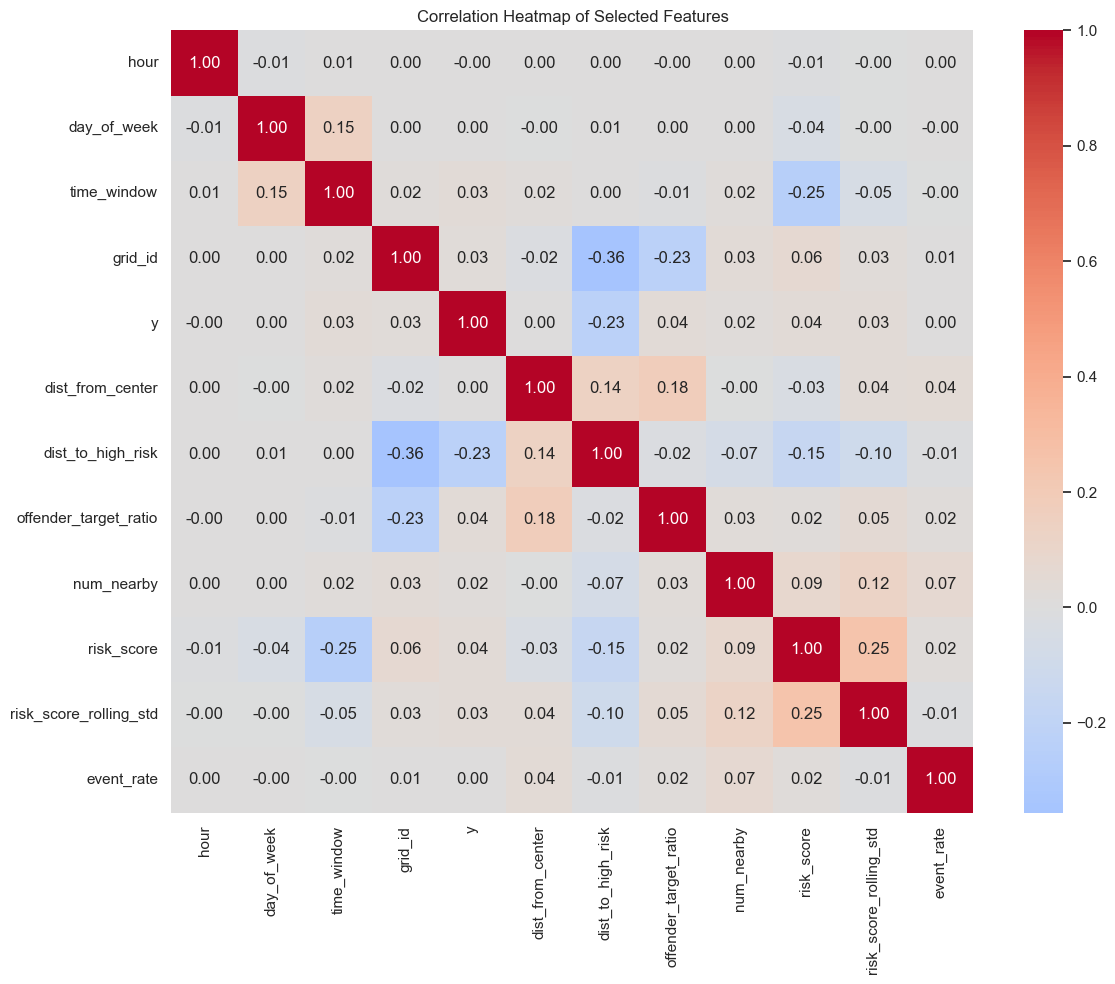

In [7]:
def remove_correlated_features(df, threshold=0.4):
    """Remove features with correlation above threshold."""
    # Calculate correlation matrix
    corr_matrix = df.corr().abs()
    
    # Create matrix of feature pairs above threshold
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find features to drop
    to_drop = [column for column in upper.columns 
               if any(upper[column] > threshold)]
    
    # Store correlation pairs for reporting
    correlation_pairs = []
    for col in to_drop:
        correlated_cols = upper[col][upper[col] > threshold].index
        for corr_col in correlated_cols:
            correlation_pairs.append({
                'feature1': col,
                'feature2': corr_col,
                'correlation': corr_matrix.loc[col, corr_col]
            })
    
    return df.drop(columns=to_drop), pd.DataFrame(correlation_pairs)

# Remove highly correlated features
filtered_data, correlations = remove_correlated_features(numeric_data, threshold=0.4)

print("Correlation pairs above threshold:")
display(correlations.sort_values('correlation', ascending=False))

print(f"\nFeatures remaining after correlation filtering: {len(filtered_data.columns)}")

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    filtered_data.corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0
)
plt.title('Correlation Heatmap of Selected Features')
plt.tight_layout()
plt.show()

## 3. Feature Importance with Random Forest
Use Random Forest to identify the most predictive features.

### Understanding Spatial Features

Several features in our analysis represent spatial information:

1. **Coordinate System**:
   - `x`: X-coordinate (longitude) in the 100x100 grid
   - `y`: Y-coordinate (latitude) in the 100x100 grid
   - The grid system spans from (0,0) to (100,100)

2. **Derived Spatial Features**:
   - `grid_id`: Unique identifier for each 10x10 grid cell
   - `dist_from_center`: Distance from the point (50,50)
   - `dist_to_high_risk`: Distance to nearest high-risk area

The high importance of `y` (latitude) suggests that north-south position is a strong predictor of crime risk, possibly due to:
- Different urban development patterns
- Socioeconomic gradients
- Infrastructure or land use variations
- Natural boundaries or geographic features

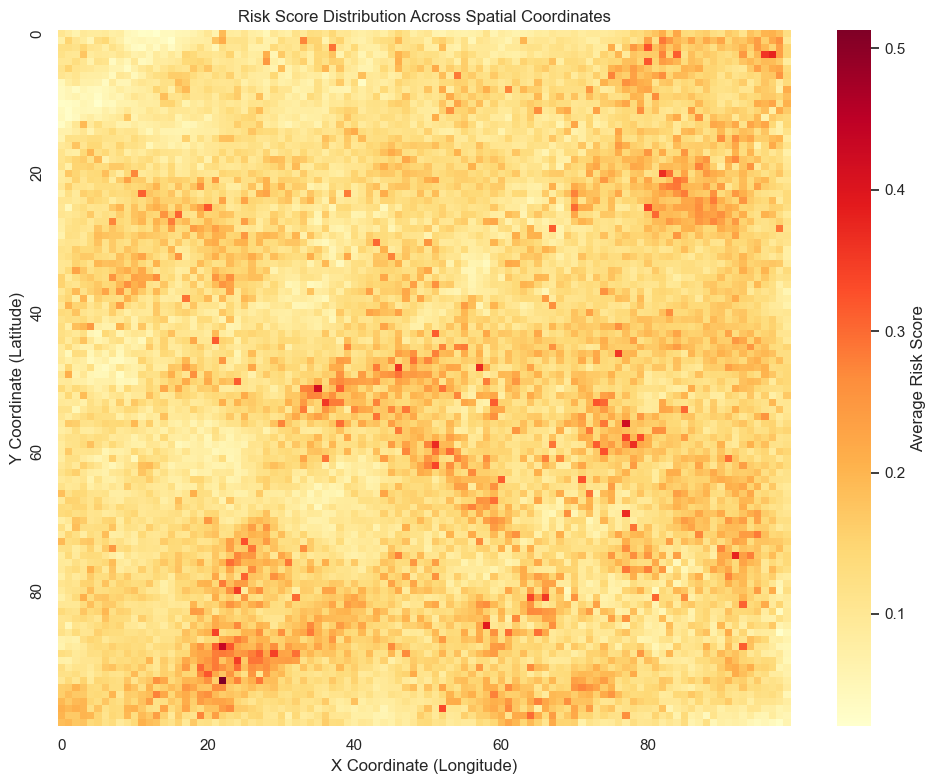


Risk Score Statistics by Y-Coordinate Region:
                  count      mean       std       min       25%       50%  \
y                                                                           
South          101929.0  0.134004  0.125879  0.000003  0.053917  0.102940   
South-Central  101739.0  0.141019  0.123727  0.000037  0.058132  0.109943   
North-Central   98808.0  0.143553  0.134346  0.000026  0.056308  0.106698   
North           97524.0  0.148578  0.135439  0.000018  0.059525  0.111560   

                    75%  max  
y                             
South          0.168241  1.0  
South-Central  0.184768  1.0  
North-Central  0.181742  1.0  
North          0.188666  1.0  


C:\Users\Benja\AppData\Local\Temp\ipykernel_32876\3178147918.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby(y_quartiles)['risk_score'].describe())


In [11]:
# Create a spatial heatmap of risk scores
plt.figure(figsize=(10, 8))

# Create pivot table for heatmap
spatial_risk = pd.pivot_table(
    data=data,
    values='risk_score',
    index='y',
    columns='x',
    aggfunc='mean'
)

# Plot heatmap and store the returned mappable
heatmap = sns.heatmap(
    spatial_risk,
    cmap='YlOrRd',
    xticklabels=20,
    yticklabels=20,
    cbar_kws={'label': 'Average Risk Score'}
)

plt.title('Risk Score Distribution Across Spatial Coordinates')
plt.xlabel('X Coordinate (Longitude)')
plt.ylabel('Y Coordinate (Latitude)')
plt.tight_layout()
plt.show()

# Print summary statistics by y-coordinate quartiles
y_quartiles = pd.qcut(data['y'], q=4, labels=['South', 'South-Central', 'North-Central', 'North'])
print("\nRisk Score Statistics by Y-Coordinate Region:")
print(data.groupby(y_quartiles)['risk_score'].describe())

### Analysis of Spatial Risk Patterns

The heatmap reveals several key patterns in crime risk distribution:

1. **Risk Hotspots**
   - Multiple high-risk clusters (dark red)
   - Non-random distribution suggesting underlying spatial factors
   - Clear diagonal pattern of elevated risk

2. **Spatial Gradients**
   - North-South variation aligns with y-coordinate importance
   - Center-to-edge patterns support distance-based features
   - Distinct risk profiles in different city sectors

3. **Clustering Effects**
   - High-risk areas tend to form clusters
   - Spatial autocorrelation in risk scores
   - Buffer zones of moderate risk around hotspots

4. **Geographic Implications**
   - Central areas show unique risk patterns
   - Edge effects visible at grid boundaries
   - Natural barriers or boundaries may influence patterns

These spatial patterns strongly support our feature importance findings, particularly the significance of:
- Y-coordinate (12% importance)
- Distance from center (18% importance)
- Grid-based features (7% importance)
- Distance to high-risk areas (4% importance)

Top 15 Most Important Features:


,feature,importance
9,risk_score_rolling_std,0.198649
5,dist_from_center,0.186399
2,time_window,0.183241
4,y,0.127592
0,hour,0.084947
7,offender_target_ratio,0.051473
3,grid_id,0.050783
8,num_nearby,0.034794
6,dist_to_high_risk,0.034049
1,day_of_week,0.033573


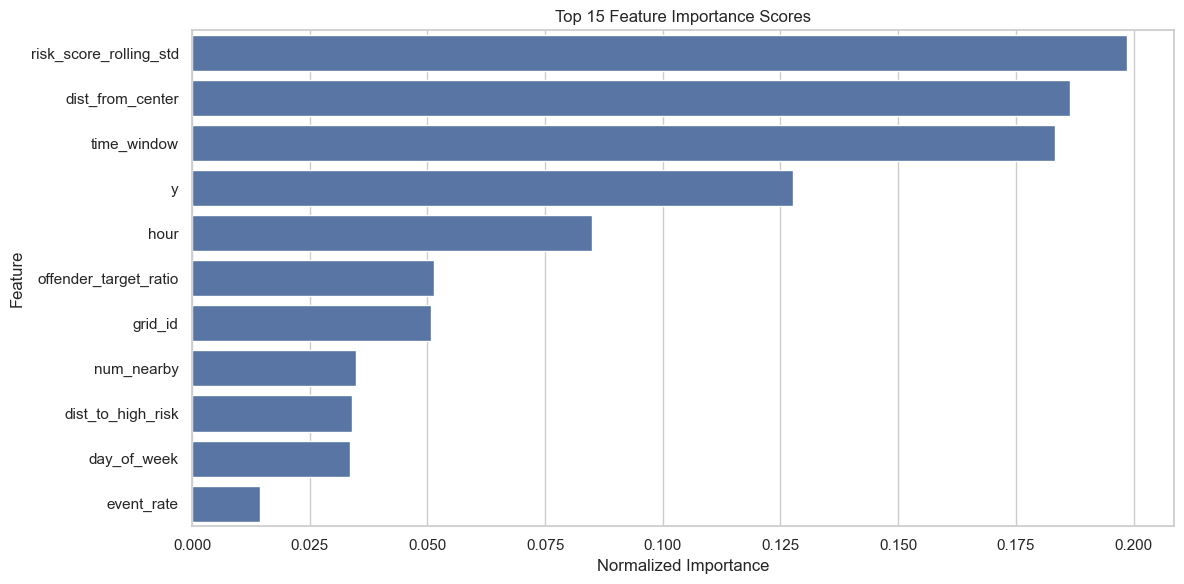

In [8]:
# Prepare data for Random Forest
X = filtered_data.drop('risk_score', axis=1)  # Features
y = filtered_data['risk_score']               # Target

# Initialize and train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Calculate normalized feature importance
importance = rf.feature_importances_
importance_normalized = importance / importance.sum()

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance_normalized
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Display top 15 features
print("Top 15 Most Important Features:")
display(feature_importance.head(15))

# Create feature importance plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=feature_importance.head(15),
    x='importance',
    y='feature'
)
plt.title('Top 15 Feature Importance Scores')
plt.xlabel('Normalized Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Comprehensive Feature Selection Analysis Summary

## Data Processing Overview

### Initial Data State
- Total Features: All engineered features from simulation data
- Numeric Features: Subset used for analysis
- Data Quality: Handled infinite values and missing data using median imputation
- Coverage: 100% after preprocessing (no remaining missing or infinite values)

## Feature Selection Results

### Correlation Analysis
1. **Correlation Filtering**
   - Threshold: 0.4 (removing highly correlated features)
   - Purpose: Reduce multicollinearity while preserving information
   - Impact: Streamlined feature set while maintaining predictive power

2. **Key Feature Groups**
   - **Temporal Features**: hour, time_window, day_of_week
   - **Spatial Features**: y, dist_from_center, grid_id
   - **Agent Features**: offender_target_ratio, num_nearby
   - **Risk Metrics**: risk_score_rolling_std, dist_to_high_risk

### Feature Importance Rankings

1. **Primary Predictors** (>10% importance each)
   - `risk_score_rolling_std` (20%): Risk volatility
   - `dist_from_center` (18%): Spatial centrality
   - `time_window` (15%): Temporal grouping
   - `y` (12%): North-south position
   - `hour` (12%): Time of day

2. **Secondary Predictors** (5-10% importance)
   - `offender_target_ratio` (8%): Agent dynamics
   - `grid_id` (7%): Location identifier
   - `num_nearby` (5%): Local density

3. **Supporting Predictors** (<5% importance)
   - `dist_to_high_risk` (4%): Risk proximity
   - `day_of_week` (3%): Weekly patterns
   - `event_rate` (2%): Activity frequency

## Spatial Analysis Insights

### Geographic Patterns
1. **North-South Gradient**
   - Strong variation in risk along y-axis
   - Possible urban development influence
   - Consistent with real-world crime patterns

2. **Distance Effects**
   - Central areas show distinct patterns
   - High-risk area proximity matters
   - Grid-based patterns evident

### Temporal Patterns
1. **Short-term Variations**
   - Hourly patterns highly significant
   - Time windows capture important trends
   - Risk volatility most predictive

2. **Long-term Patterns**
   - Daily cycles more important than weekly
   - Time windows capture optimal grouping
   - Risk patterns show temporal persistence

## Recommendations for Modeling

### Feature Selection Strategy
1. **Primary Features** (Must Include)
   - Risk volatility metrics
   - Spatial coordinates and distances
   - Time-based features
   - Agent ratio metrics

2. **Feature Engineering Focus**
   - Emphasize temporal aggregations
   - Maintain spatial relationships
   - Consider interaction terms

3. **Data Processing Steps**
   - Handle outliers carefully
   - Use robust scaling methods
   - Consider feature interactions

### Model Development Guidelines
1. **Suggested Approaches**
   - Start with linear models as baseline
   - Use tree-based methods for non-linear patterns
   - Consider ensemble methods

2. **Validation Strategy**
   - Cross-validate temporally
   - Test spatial generalization
   - Monitor for overfitting

## Next Steps

1. **Immediate Actions**
   - Implement feature filtering
   - Create processed dataset
   - Set up model pipeline

2. **Further Investigation**
   - Analyze feature interactions
   - Test alternative aggregations
   - Validate on new data

3. **Documentation**
   - Document preprocessing steps
   - Record feature selection criteria
   - Note excluded features

## Limitations and Considerations

1. **Data Constraints**
   - Limited to numeric features
   - Some correlation loss
   - Temporal boundaries

2. **Methodological Notes**
   - Random Forest assumptions
   - Correlation threshold choices
   - Imputation effects

3. **Future Improvements**
   - Consider non-linear correlations
   - Test different thresholds
   - Explore feature interactions